In [1]:
import Pkg

In [ ]:
Pkg.add("GenieFramework")

In [10]:
Pkg.add("Flux")

   Resolving package versions...
   Installed CEnum ──────────────── v0.5.0
   Installed ContextVariablesX ──── v0.1.3
   Installed ShowCases ──────────── v0.1.0
   Installed Optimisers ─────────── v0.3.3
   Installed DelimitedFiles ─────── v1.9.1
   Installed InitialValues ──────── v0.3.1
   Installed NNlib ──────────────── v0.9.17
   Installed StaticArrays ───────── v1.9.5
   Installed ZygoteRules ────────── v0.2.5
   Installed PrettyPrint ────────── v0.2.0
   Installed MLUtils ────────────── v0.4.4
   Installed RealDot ────────────── v0.1.0
   Installed IrrationalConstants ── v0.2.2
   Installed IRTools ────────────── v0.4.14
   Installed GPUArrays ──────────── v10.2.0
   Installed LLVM ───────────────── v7.2.1
   Installed Functors ───────────── v0.4.11
   Installed FLoopsBase ─────────── v0.1.1
   Installed ProgressLogging ────── v0.1.4
   Installed SpecialFunctions ───── v2.4.0
   Installed OneHotArrays ───────── v0.2.5
   Installed StaticArraysCore ───── v1.4.3
   Installed Zygo

In [22]:
using GraphNeuralNetworks, Graphs, Flux, CUDA, Statistics, MLUtils
using Flux: DataLoader

all_graphs = GNNGraph[]

for _ in 1:1000
    g = rand_graph(10, 40,  
            ndata=(; x = randn(Float32, 16,10)),  # input node features
            gdata=(; y = randn(Float32)))         # regression target   
    push!(all_graphs, g)
end

In [23]:
using CUDA
using Flux
using Statistics

device = CUDA.functional() ? Flux.gpu : Flux.cpu;

model = GNNChain(GCNConv(16 => 64),
                BatchNorm(64),     # Apply batch normalization on node features (nodes dimension is batch dimension)
                x -> relu.(x),     
                GCNConv(64 => 64, relu),
                GlobalPool(mean),  # aggregate node-wise features into graph-wise features
                Dense(64, 1)) |> device

opt = Flux.setup(Adam(1f-4), model)

(layers = ((weight = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = (), add_self_loops = (), use_edge_weight = ()), (λ = (), β = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), γ = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  

In [24]:
train_graphs, test_graphs = MLUtils.splitobs(all_graphs, at=0.8)

train_loader = DataLoader(train_graphs, 
                batchsize=32, shuffle=true, collate=true)
test_loader = DataLoader(test_graphs, 
                batchsize=32, shuffle=false, collate=true)

loss(model, g::GNNGraph) = mean((vec(model(g, g.x)) - g.y).^2)

loss(model, loader) = mean(loss(model, g |> device) for g in loader)

for epoch in 1:100
    for g in train_loader
        g = g |> device
        grad = gradient(model -> loss(model, g), model)
        Flux.update!(opt, model, grad[1])
    end

    @info (; epoch, train_loss=loss(model, train_loader), test_loss=loss(model, test_loader))
end

┌ Info: (epoch = 1, train_loss = 1.2600845f0, test_loss = 1.0961782f0)
└ @ Main c:\Users\HP\Desktop\renewedSGC\eSGCe.ipynb:19
┌ Info: (epoch = 2, train_loss = 1.2290423f0, test_loss = 1.0788988f0)
└ @ Main c:\Users\HP\Desktop\renewedSGC\eSGCe.ipynb:19
┌ Info: (epoch = 3, train_loss = 1.1283885f0, test_loss = 1.0220898f0)
└ @ Main c:\Users\HP\Desktop\renewedSGC\eSGCe.ipynb:19
┌ Info: (epoch = 4, train_loss = 1.0818628f0, test_loss = 1.0048438f0)
└ @ Main c:\Users\HP\Desktop\renewedSGC\eSGCe.ipynb:19
┌ Info: (epoch = 5, train_loss = 1.0605927f0, test_loss = 1.0004151f0)
└ @ Main c:\Users\HP\Desktop\renewedSGC\eSGCe.ipynb:19
┌ Info: (epoch = 6, train_loss = 1.0487541f0, test_loss = 0.9881182f0)
└ @ Main c:\Users\HP\Desktop\renewedSGC\eSGCe.ipynb:19
┌ Info: (epoch = 7, train_loss = 1.0336763f0, test_loss = 0.98587227f0)
└ @ Main c:\Users\HP\Desktop\renewedSGC\eSGCe.ipynb:19
┌ Info: (epoch = 8, train_loss = 1.0227753f0, test_loss = 0.9728089f0)
└ @ Main c:\Users\HP\Desktop\renewedSGC\eSGCe.

In [18]:
#https://carlolucibello.github.io/GraphNeuralNetworks.jl/dev/api/conv/

#GraphNeuralNetworks.SGConv—Type

using GraphNeuralNetworks

# create data
s = [1,1,2,3]
t = [2,3,1,1]
g = GNNGraph(s, t)
x = randn(Float32, 3, g.num_nodes)

# create layer
l = SGConv(3 => 5; add_self_loops = true) 

# forward pass
y = l(g, x)       # size:  5 × num_nodes

# convolution with edge weights
w = [1.1, 0.1, 2.3, 0.5]
y = l(g, x, w)

# Edge weights can also be embedded in the graph.
g = GNNGraph(s, t, w)
l = SGConv(3 => 5, add_self_loops = true, use_edge_weight=true) 
y = l(g, x) # same as l(g, x, w) 

5×3 Matrix{Float64}:
 -0.150365    -0.473152   0.538996
  0.735801     0.391739  -0.357397
  0.00063069   0.607523   0.726568
  0.316359    -0.39287   -0.702456
 -0.389747    -0.115333   0.23436

In [3]:
import Pkg

In [16]:
Pkg.add("GNNGraph")

Pkg.Types.PkgError: The following package names could not be resolved:
 * GNNGraph (not found in project, manifest or registry)
[36m   Suggestions:[39m [0m[1mG[22me[0m[1mn[22mLi[0m[1mn[22mearAl[0m[1mg[22meb[0m[1mr[22m[0m[1ma[22m Ti[0m[1mg[22mhtBi[0m[1mn[22mdi[0m[1mn[22m[0m[1mg[22mApp[0m[1mr[22moxim[0m[1ma[22mtion [0m[1mG[22me[0m[1mn[22mericLi[0m[1mn[22mearAl[0m[1mg[22meb[0m[1mr[22m[0m[1ma[22m

In [17]:
Pkg.add("GraphNeuralNetworks")

   Resolving package versions...
  No Changes to `C:\Users\HP\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\HP\.julia\environments\v1.10\Manifest.toml`


In [13]:
Pkg.add("Graphs")

   Resolving package versions...
    Updating `C:\Users\HP\.julia\environments\v1.10\Project.toml`
  [86223c79] + Graphs v1.11.1
  No Changes to `C:\Users\HP\.julia\environments\v1.10\Manifest.toml`


In [14]:
Pkg.add("CUDA")

   Resolving package versions...
   Installed BFloat16s ────────────── v0.5.0
   Installed LLVMLoopInfo ─────────── v1.0.0
   Installed NVTX_jll ─────────────── v3.1.0+2
   Installed CUDA_Runtime_Discovery ─ v0.3.3
   Installed CUDA_Runtime_jll ─────── v0.14.0+1
   Installed CUDA_Driver_jll ──────── v0.9.0+0
   Installed TimerOutputs ─────────── v0.5.24
   Installed RandomNumbers ────────── v1.5.3
   Installed Random123 ────────────── v1.7.0
   Installed JuliaNVTXCallbacks_jll ─ v0.2.1+0
   Installed NVTX ─────────────────── v0.3.4
   Installed GPUCompiler ──────────── v0.26.5
   Installed CUDA ─────────────────── v5.4.2
    Updating `C:\Users\HP\.julia\environments\v1.10\Project.toml`
  [052768ef] + CUDA v5.4.2
    Updating `C:\Users\HP\.julia\environments\v1.10\Manifest.toml`
  [ab4f0b2a] + BFloat16s v0.5.0
  [052768ef] + CUDA v5.4.2
  [1af6417a] + CUDA_Runtime_Discovery v0.3.3
  [e2ba6199] + ExprTools v0.1.10
  [61eb1bfa] + GPUCompiler v0.26.5
  [8b046642] + LLVMLoopInfo v1.0.0
  [5

In [15]:
Pkg.add("Statistics")

   Resolving package versions...
    Updating `C:\Users\HP\.julia\environments\v1.10\Project.toml`
  [10745b16] + Statistics v1.10.0
  No Changes to `C:\Users\HP\.julia\environments\v1.10\Manifest.toml`


In [16]:
Pkg.add("MLUtils")

   Resolving package versions...
    Updating `C:\Users\HP\.julia\environments\v1.10\Project.toml`
  [f1d291b0] + MLUtils v0.4.4
  No Changes to `C:\Users\HP\.julia\environments\v1.10\Manifest.toml`


In [18]:
Pkg.add("cuDNN")

   Resolving package versions...
   Installed CUDNN_jll ─ v9.0.0+1
   Installed cuDNN ───── v1.3.2
    Updating `C:\Users\HP\.julia\environments\v1.10\Project.toml`
  [02a925ec] + cuDNN v1.3.2
    Updating `C:\Users\HP\.julia\environments\v1.10\Manifest.toml`
  [02a925ec] + cuDNN v1.3.2
⌅ [62b44479] + CUDNN_jll v9.0.0+1
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`
Precompiling project...
  ✓ CUDNN_jll
  ✓ cuDNN
  ✓ NNlib → NNlibCUDACUDNNExt
  ✓ Flux → FluxCUDAcuDNNExt
  4 dependencies successfully precompiled in 22 seconds. 223 already precompiled.


In [26]:
Pkg.add("MLDatasets")

   Resolving package versions...
   Installed OffsetArrays ─────────── v1.14.0
   Installed GZip ─────────────────── v0.6.2
   Installed JLD2 ─────────────────── v0.4.48
   Installed Unitful ──────────────── v1.20.0
   Installed FileIO ───────────────── v1.16.3
   Installed Chemfiles ────────────── v0.10.41
   Installed MAT ──────────────────── v0.10.7
   Installed AtomsBase ────────────── v0.3.5
   Installed WorkerUtilities ──────── v1.6.1
   Installed MPIPreferences ───────── v0.1.11
   Installed MappedArrays ─────────── v0.4.2
   Installed PaddedViews ──────────── v0.5.12
   Installed StridedViews ─────────── v0.2.2
   Installed HDF5_jll ─────────────── v1.12.2+2
   Installed BufferedStreams ──────── v1.2.1
   Installed LazyModules ──────────── v0.3.1
   Installed PeriodicTable ────────── v1.2.1
   Installed MosaicViews ──────────── v0.3.4
   Installed ColorSchemes ─────────── v3.25.0
   Installed TensorCore ───────────── v0.1.1
   Installed ImageCore ────────────── v0.10.2
   Insta

In [28]:
Pkg.add("GraphMakie")

   Resolving package versions...
   Installed libfdk_aac_jll ──────────── v2.0.2+0
   Installed Libmount_jll ────────────── v2.40.1+0
   Installed x265_jll ────────────────── v3.5.0+0
   Installed JpegTurbo_jll ───────────── v3.0.3+0
   Installed Calculus ────────────────── v0.5.1
   Installed ImageIO ─────────────────── v0.6.8
   Installed AxisArrays ──────────────── v0.4.7
   Installed TiffImages ──────────────── v0.10.0
   Installed JpegTurbo ───────────────── v0.1.5
   Installed StatsFuns ───────────────── v1.3.1
   Installed FFTW ────────────────────── v1.8.0
   Installed HypergeometricFunctions ─── v0.3.23
   Installed PNGFiles ────────────────── v0.4.3
   Installed Opus_jll ────────────────── v1.3.2+0
   Installed RelocatableFolders ──────── v1.0.1
   Installed GraphMakie ──────────────── v0.5.11
   Installed Sixel ───────────────────── v0.1.3
   Installed PDMats ──────────────────── v0.11.31
   Installed NetworkLayout ───────────── v0.4.6
   Installed Grisu ────────────────────

In [30]:
Pkg.add("CairoMakie")

   Resolving package versions...
   Installed CairoMakie ─ v0.12.2
   Installed Pango_jll ── v1.52.2+0
   Installed Graphics ─── v1.1.2
   Installed Cairo ────── v1.0.5
    Updating `C:\Users\HP\.julia\environments\v1.10\Project.toml`
  [13f3f980] + CairoMakie v0.12.2
    Updating `C:\Users\HP\.julia\environments\v1.10\Manifest.toml`
  [159f3aea] + Cairo v1.0.5
  [13f3f980] + CairoMakie v0.12.2
  [a2bd30eb] + Graphics v1.1.2
  [36c8627f] + Pango_jll v1.52.2+0
Precompiling project...
  ✓ Graphics
  ✓ Pango_jll
  ✓ Cairo
CairoMakie Waiting for background task / IO / timer.
[pid 2596] waiting for IO to finish:
 Handle type        uv_handle_t->data
 timer              000001b179a01560->000001b106b9e1a0
This means that a package has started a background task or event source that has not finished running. For precompilation to complete successfully, the event source needs to be closed explicitly. See the developer documentation on fixing precompilation hangs for more help.
  ✓ CairoMakie
  4

In [31]:
Pkg.add("PlutoUI")

   Resolving package versions...
   Installed AbstractPlutoDingetjes ─ v1.3.2
   Installed Hyperscript ──────────── v0.0.5
   Installed Tricks ───────────────── v0.1.8
   Installed HypertextLiteral ─────── v0.9.5
   Installed IOCapture ────────────── v0.2.5
   Installed PlutoUI ──────────────── v0.7.59
    Updating `C:\Users\HP\.julia\environments\v1.10\Project.toml`
  [7f904dfe] + PlutoUI v0.7.59
    Updating `C:\Users\HP\.julia\environments\v1.10\Manifest.toml`
  [6e696c72] + AbstractPlutoDingetjes v1.3.2
  [47d2ed2b] + Hyperscript v0.0.5
  [ac1192a8] + HypertextLiteral v0.9.5
  [b5f81e59] + IOCapture v0.2.5
  [7f904dfe] + PlutoUI v0.7.59
  [410a4b4d] + Tricks v0.1.8
Precompiling project...
  ✓ IOCapture
  ✓ Tricks
  ✓ Hyperscript
  ✓ AbstractPlutoDingetjes
  ✓ HypertextLiteral
  ✓ PlutoUI
  6 dependencies successfully precompiled in 27 seconds. 405 already precompiled.


In [32]:
#https://carlolucibello.github.io/GraphNeuralNetworks.jl/dev/tutorials/introductory_tutorials/gnn_intro_pluto/#Hands-on-introduction-to-Graph-Neural-Networks
begin
    using Flux
    using Flux: onecold, onehotbatch, logitcrossentropy
    using MLDatasets
    using LinearAlgebra, Random, Statistics
    import GraphMakie
    import CairoMakie as Makie
    using Graphs
    using PlutoUI
    using GraphNeuralNetworks
end

In [33]:
begin
    ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"  # don't ask for dataset download confirmation
    Random.seed!(17) # for reproducibility
end;

In [34]:
#Following Kipf et al. (2017), let's dive into the world of GNNs by looking at a simple graph-structured example, the well-known Zachary's karate club network. This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

#GraphNeuralNetworks.jl provides utilities to convert MLDatasets.jl's datasets to its own type:

dataset = MLDatasets.KarateClub()

dataset KarateClub:
  metadata  =>    Dict{String, Any} with 0 entries
  graphs    =>    1-element Vector{MLDatasets.Graph}

In [40]:
dataset KarateClub:
  metadata  =>    Dict{String, Any} 
  graphs    =>    {MLDatasets.Graph}

Base.Meta.ParseError: ParseError:
# Error @ c:\Users\HP\Desktop\renewedSGC\eSGCe.ipynb:1:8
dataset KarateClub:
#      └──────────┘ ── extra tokens after end of expression

In [ ]:
#After initializing the KarateClub dataset, we first can inspect some of its properties. For example, we can see that this dataset holds exactly one graph. Furthermore, the graph holds exactly 4 classes, which represent the community each node belongs to.

In [41]:
karate = dataset[1]

Graph:
  num_nodes   =>    34
  num_edges   =>    156
  edge_index  =>    ("156-element Vector{Int64}", "156-element Vector{Int64}")
  node_data   =>    (labels_clubs = "34-element Vector{Int64}", labels_comm = "34-element Vector{Int64}")
  edge_data   =>    nothing

In [42]:
karate.node_data.labels_comm

34-element Vector{Int64}:
 1
 1
 1
 1
 3
 3
 3
 1
 0
 1
 ⋮
 2
 0
 0
 2
 0
 0
 2
 0
 0

In [43]:
#Now we convert the single-graph dataset to a GNNGraph. Moreover, we add a an array of node features, a 34-dimensional feature vector for each node which uniquely describes the members of the karate club. We also add a training mask selecting the nodes to be used for training in our semi-supervised node classification task.

begin
    # convert a MLDataset.jl's dataset to a GNNGraphs (or a collection of graphs)
    g = mldataset2gnngraph(dataset)

    x = zeros(Float32, g.num_nodes, g.num_nodes)
    x[diagind(x)] .= 1

    train_mask = [true, false, false, false, true, false, false, false, true,
        false, false, false, false, false, false, false, false, false, false, false,
        false, false, false, false, true, false, false, false, false, false,
        false, false, false, false]

    labels = g.ndata.labels_comm
    y = onehotbatch(labels, 0:3)

    g = GNNGraph(g, ndata = (; x, y, train_mask))
end

GNNGraph:
  num_nodes: 34
  num_edges: 156
  ndata:
	y = 4×34 OneHotMatrix(::Vector{UInt32}) with eltype Bool
	train_mask = 34-element Vector{Bool}
	x = 34×34 Matrix{Float32}

In [44]:
with_terminal() do
    # Gather some statistics about the graph.
    println("Number of nodes: $(g.num_nodes)")
    println("Number of edges: $(g.num_edges)")
    println("Average node degree: $(g.num_edges / g.num_nodes)")
    println("Number of training nodes: $(sum(g.ndata.train_mask))")
    println("Training node label rate: $(mean(g.ndata.train_mask))")
    # println("Has isolated nodes: $(has_isolated_nodes(g))")
    println("Has self-loops: $(has_self_loops(g))")
    println("Is undirected: $(is_bidirected(g))")
end

PlutoUI.TerminalNotebook.WithTerminalOutput(nothing, "Number of nodes: 34\nNumber of edges: 156\nAverage node degree: 4.588235294117647\nNumber of training nodes: 4\nTraining node label rate: 0.11764705882352941\nHas self-loops: false\nIs undirected: true\n", true)

In [45]:
edge_index(g)

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  34, 34, 34, 34, 34, 34, 34, 34, 34, 34], [2, 3, 4, 5, 6, 7, 8, 9, 11, 12  …  21, 23, 24, 27, 28, 29, 30, 31, 32, 33])

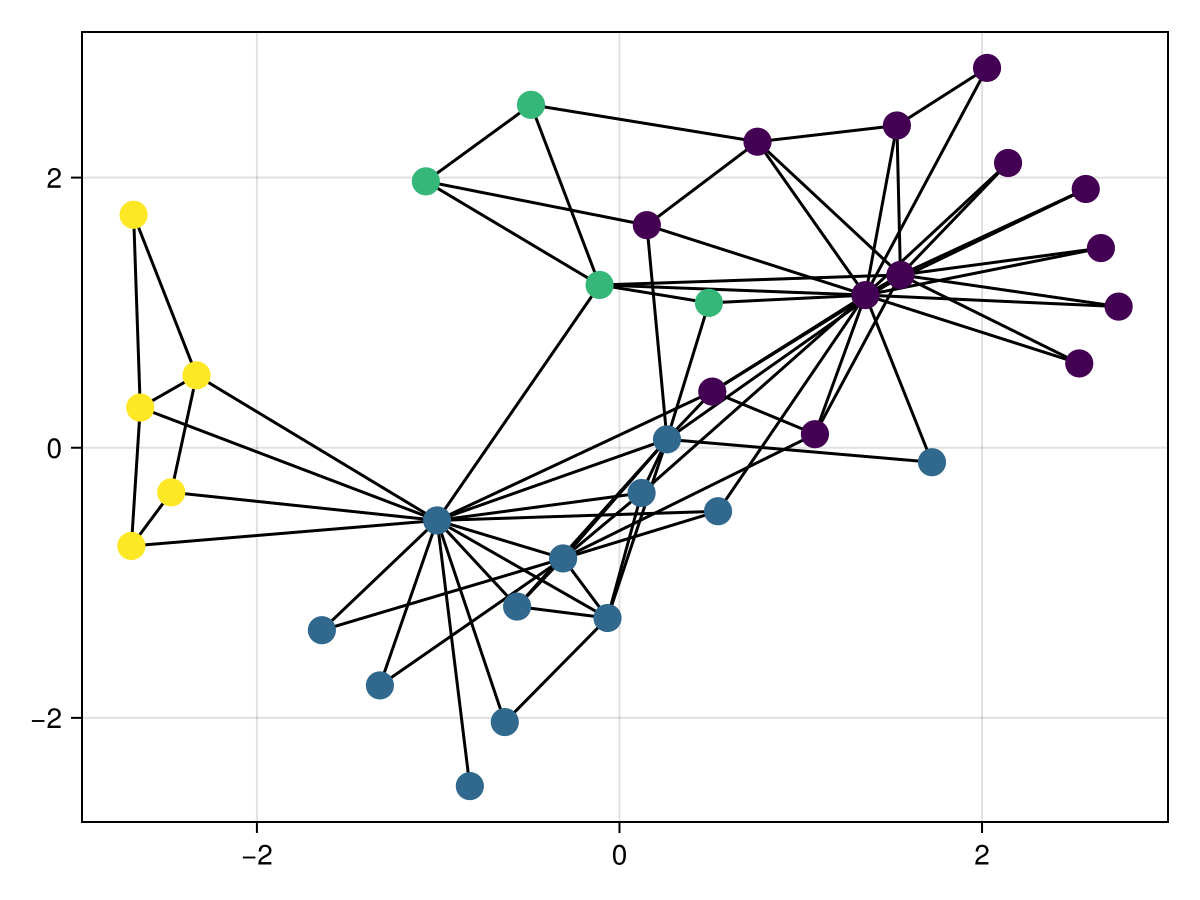

In [46]:
GraphMakie.graphplot(g |> to_unidirected, node_size = 20, node_color = labels,
                     arrow_show = false)

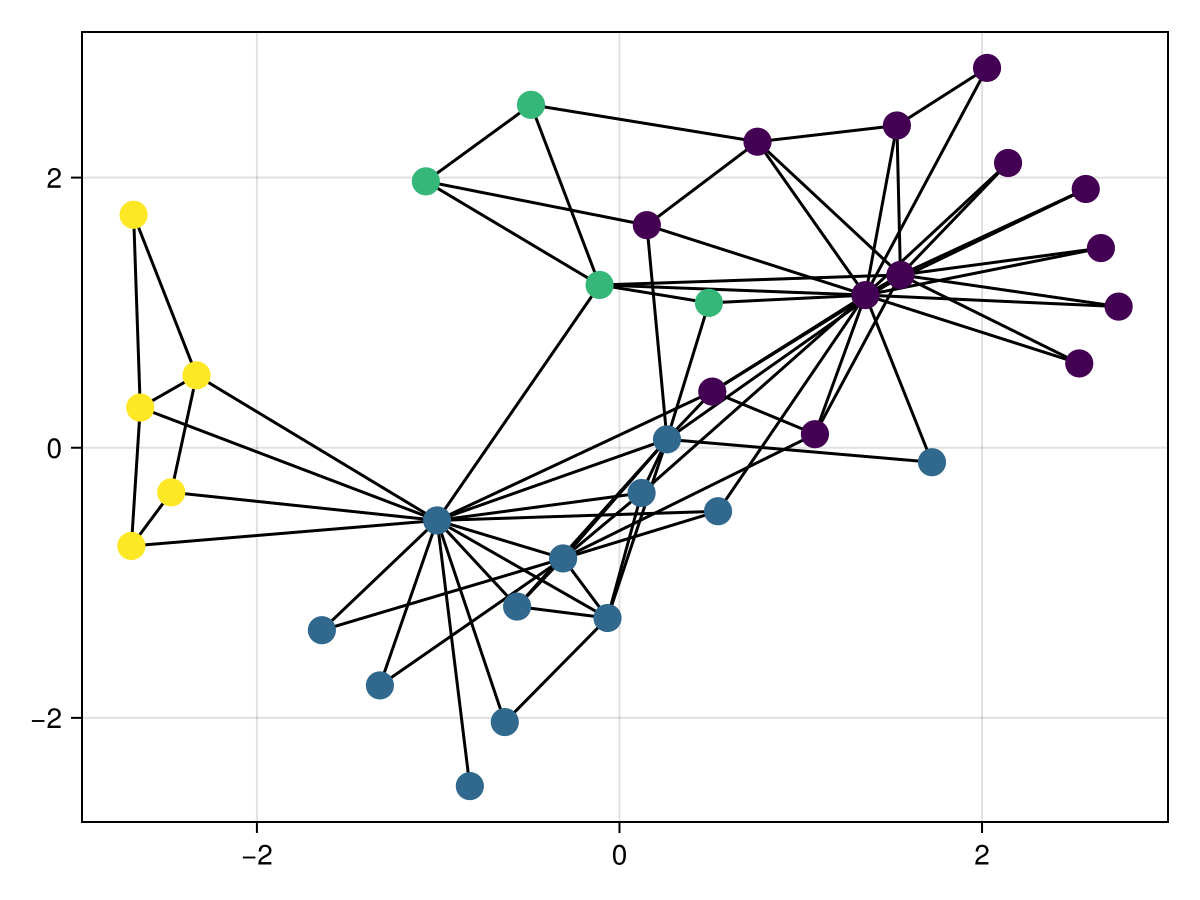

In [47]:
GraphMakie.graphplot(g |> to_unidirected, node_size = 20, node_color = labels,
                     arrow_show = false)

In [48]:
#Implementing Graph Neural Networks
#https://arxiv.org/pdf/1609.02907

begin
    struct GCN
        layers::NamedTuple
    end

    Flux.@functor GCN # provides parameter collection, gpu movement and more

    function GCN(num_features, num_classes)
        layers = (conv1 = GCNConv(num_features => 4),
                  conv2 = GCNConv(4 => 4),
                  conv3 = GCNConv(4 => 2),
                  classifier = Dense(2, num_classes))
        return GCN(layers)
    end

    function (gcn::GCN)(g::GNNGraph, x::AbstractMatrix)
        l = gcn.layers
        x = l.conv1(g, x)
        x = tanh.(x)
        x = l.conv2(g, x)
        x = tanh.(x)
        x = l.conv3(g, x)
        x = tanh.(x)  # Final GNN embedding space.
        out = l.classifier(x)
        # Apply a final (linear) classifier.
        return out, x
    end
end

In [ ]:
#GraphNeuralNetworks.jl implements this layer via GCNConv, which can be executed by passing in the node feature representation x and the COO graph connectivity representation edge_index.

#With this, we are ready to create our first Graph Neural Network by defining our network architecture:

In [49]:
#Embedding the Karate Club Network
#Let's take a look at the node embeddings produced by our GNN. Here, we pass in the initial node features x and the graph information g to the model, and visualize its 2-dimensional embedding.

begin
    num_features = 34
    num_classes = 4
    gcn = GCN(num_features, num_classes)
end

GCN((conv1 = GCNConv(34 => 4), conv2 = GCNConv(4 => 4), conv3 = GCNConv(4 => 2), classifier = Dense(2 => 4)))

In [50]:
_, h = gcn(g, g.ndata.x)

(Float32[0.02146625 0.025838671 … -0.0042725513 0.0056721903; 0.16082448 0.14679235 … -0.003681789 0.040167753; -0.09757348 -0.0888333 … 0.0020964658 -0.02435881; 0.114049815 0.106652185 … -0.004156831 0.028612293], Float32[-0.23871674 -0.21151944 … 0.0016090268 -0.05930534; -0.050135512 -0.05729834 … 0.008132701 -0.01309597])

In [54]:
function visualize_embeddings(h; colors = nothing)
    xs = h[1, :] |> vec
    ys = h[2, :] |> vec
    Makie.scatter(xs, ys, color = labels, markersize = 20)
end

visualize_embeddings (generic function with 1 method)

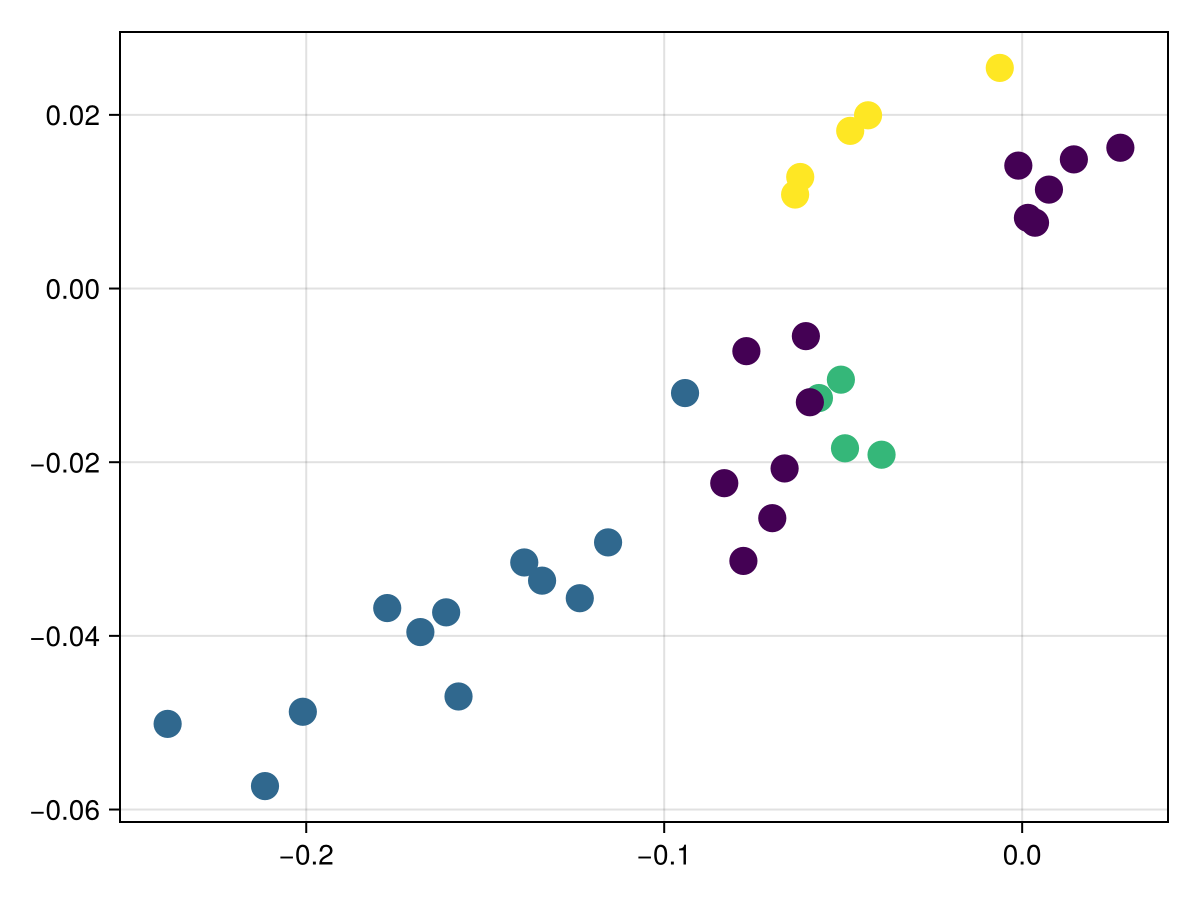

In [55]:
visualize_embeddings(h, colors = labels)

In [63]:
ŷ, emb_final = model(g, g.ndata.x)

(Float32[0.034926727 0.0023777345 … -0.044007044 -0.038444098; -0.01695336 0.0010127436 … 0.0046670553 0.0021591787; 0.029201005 -0.00030956985 … -0.01909257 -0.014645549; 0.027973512 0.00042845277 … -0.023875516 -0.019551067], Float32[0.016698465 0.0021373339 … -0.028747983 -0.025999516; -0.03929502 -0.0008207072 … 0.03522451 0.029130429])

In [64]:
# train accuracy
mean(onecold(ŷ[:, train_mask]) .== onecold(y[:, train_mask]))

0.0

In [65]:
# train accuracy
mean(onecold(ŷ[:, train_mask]) .== onecold(y[:, train_mask]))

0.0

In [66]:
# test accuracy
mean(onecold(ŷ[:, .!train_mask]) .== onecold(y[:, .!train_mask]))

0.1

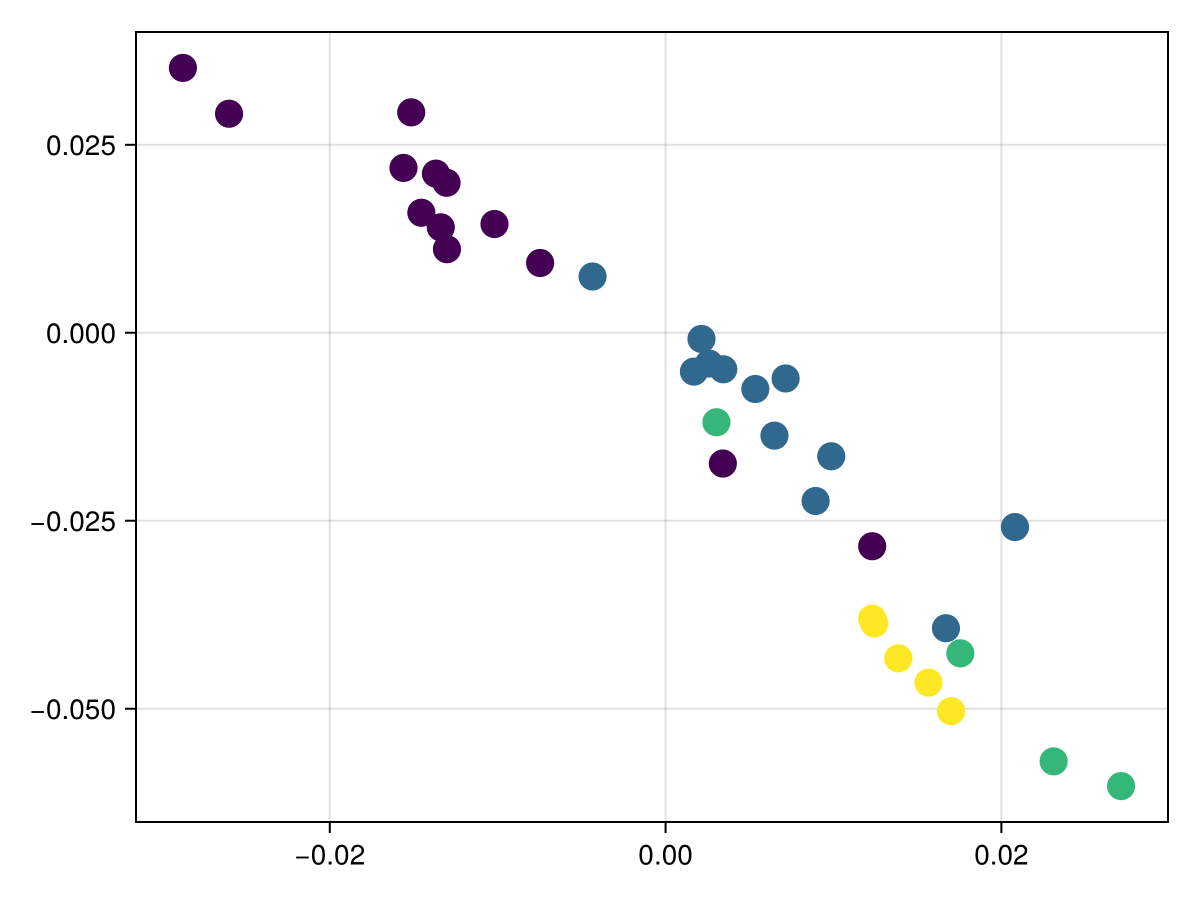

In [67]:
visualize_embeddings(emb_final, colors = labels)

In [69]:
loss = logitcrossentropy(ŷ[:,train_mask], y[:,train_mask])

ErrorException: invalid redefinition of constant Main.loss

In [56]:
#But can we do better? Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community).

#Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observe how the embeddings react. Here, we make use of a semi-supervised or transductive learning procedure: we simply train against one node per class, but are allowed to make use of the complete input graph data.

#Training our model is very similar to any other Flux model. In addition to defining our network architecture, we define a loss criterion (here, logitcrossentropy), and initialize a stochastic gradient optimizer (here, Adam). After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass. If you are not new to Flux, this scheme should appear familiar to you.

#Note that our semi-supervised learning scenario is achieved by the following line:

begin
    model = GCN(num_features, num_classes)
    opt = Flux.setup(Adam(1e-2), model)
    epochs = 2000

    emb = h
    function report(epoch, loss, h)
        # p = visualize_embeddings(h)
        @info (; epoch, loss)
    end

    report(0, 10.0, emb)
    for epoch in 1:epochs
        loss, grad = Flux.withgradient(model) do model
            ŷ, emb = model(g, g.ndata.x)
            logitcrossentropy(ŷ[:, train_mask], y[:, train_mask])
        end

        Flux.update!(opt, model, grad[1])
        if epoch % 200 == 0
            report(epoch, loss, emb)
        end
    end
end

┌ Info: (epoch = 0, loss = 10.0)
└ @ Main c:\Users\HP\Desktop\renewedSGC\eSGCe.ipynb:17


ErrorException: invalid redefinition of constant Main.loss

In [61]:
begin
    model = GCN(num_features, num_classes)
    opt = Flux.setup(Adam(1e-2), model)
    epochs = 2000

    emb = h
    function report(epoch, loss, h)
        # p = visualize_embeddings(h)
        @info (; epoch, loss)
    end

    report(0, 10.0, emb)
    for epoch in 1:epochs
        loss, grad = Flux.withgradient(model) do model
            ŷ, emb = model(g, g.ndata.x)
            logitcrossentropy(ŷ[:, train_mask], y[:, train_mask])
        end

        Flux.update!(opt, model, grad[1])
        if epoch % 200 == 0
            report(epoch, loss, emb)
        end
    end
end

┌ Info: (epoch = 0, loss = 10.0)
└ @ Main c:\Users\HP\Desktop\renewedSGC\eSGCe.ipynb:9


ErrorException: invalid redefinition of constant Main.loss

In [ ]:
#https://carlolucibello.github.io/GraphNeuralNetworks.jl/dev/tutorials/

https://carlolucibello.github.io/GraphNeuralNetworks.jl/dev/tutorials/introductory_tutorials/traffic_prediction/#Traffic-Prediction-using-recurrent-Temporal-Graph-Convolutional-Network

In [ ]:
#Traffic Prediction using recurrent Temporal Graph Convolutional Network

In [74]:
begin
    using GraphNeuralNetworks
    using Flux
    using Flux.Losses: mae
    using MLDatasets: METRLA
    using Statistics
    using Plots
end

In [73]:
Pkg.add("Plots")

   Resolving package versions...
   Installed GR_jll ─────────────────────── v0.73.5+0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.6+0
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
   Installed LERC_jll ───────────────────── v3.0.0+1
   Installed Xorg_xcb_util_image_jll ────── v0.4.0+1
   Installed RecipesPipeline ────────────── v0.6.12
   Installed Measures ───────────────────── v0.3.2
   Installed Xorg_libSM_jll ─────────────── v1.2.4+0
   Installed Xorg_xcb_util_jll ──────────── v0.4.0+1
   Installed FFMPEG ─────────────────────── v0.4.1
   Installed Xorg_libXinerama_jll ───────── v1.1.4+4
   Installed Xorg_libxkbfile_jll ────────── v1.1.2+0
   Installed Xorg_xcb_util_keysyms_jll ──── v0.4.0+1
   Installed xkbcommon_jll ──────────────── v1.4.1+1
   Installed EpollShim_jll ──────────────── v0.0.20230411+0
   Installed Pipe ───────────────────────── v1.3.0
   Installed XZ_jll ─────────────────────── v5.4.6+0
   Installed PlotThemes ─────────────────── v3.2.0
   Installed f

In [75]:
#https://arxiv.org/pdf/1707.01926

#We use the METR-LA dataset from the paper Diffusion Convolutional Recurrent Neural Network: Data-driven Traffic Forecasting, which contains traffic data from loop detectors in the highway of Los Angeles County. The dataset contains traffic speed data from March 1, 2012 to June 30, 2012. The data is collected every 5 minutes, resulting in 12 observations per hour, from 207 sensors. Each sensor is a node in the graph, and the edges represent the distances between the sensors.

dataset_metrla = METRLA(; num_timesteps = 3)


7-Zip 21.07 (x64) : Copyright (c) 1999-2021 Igor Pavlov : 2021-12-26

Scanning the drive for archives:
1 file, 10931511 bytes (11 MiB)

Extracting archive: C:\Users\HP\.julia\scratchspaces\124859b0-ceae-595e-8997-d05f6a7a8dfe\datadeps\METRLA\METRLA.zip
--
Path = C:\Users\HP\.julia\scratchspaces\124859b0-ceae-595e-8997-d05f6a7a8dfe\datadeps\METRLA\METRLA.zip
Type = zip
Physical Size = 10931511

Everything is Ok

Size:       56926732
Compressed: 10931511


dataset METRLA:
  graphs  =>    1-element Vector{MLDatasets.Graph}

In [77]:
g = dataset_metrla[1]

Graph:
  num_nodes   =>    207
  num_edges   =>    1722
  edge_index  =>    ("1722-element Vector{Int64}", "1722-element Vector{Int64}")
  node_data   =>    (features = "34269-element Vector{Any}", targets = "34269-element Vector{Any}")
  edge_data   =>    1722-element Vector{Float32}

In [78]:
#edge_data contains the weights of the edges of the graph and node_data contains a node feature vector and a target vector. The latter vectors contain batches of dimension num_timesteps, which means that they contain vectors with the node features and targets of num_timesteps time steps. Two consecutive batches are shifted by one-time step. The node features are the traffic speed of the sensors and the time of the day, and the targets are the traffic speed of the sensors in the next time step. Let's see some examples:

size(g.node_data.features[1])

(2, 207, 3)

In [79]:
#The first dimension correspond to the two features (first line the speed value and the second line the time of the day), the second to the nodes and the third to the number of timestep num_timesteps.

size(g.node_data.targets[1])

(1, 207, 3)

In [80]:
g.node_data.features[1][:,1,:]

2×3 Matrix{Float32}:
  1.17081    1.11647   1.15888
 -0.876741  -0.87663  -0.87652

In [81]:
g.node_data.features[2][:,1,:]

2×3 Matrix{Float32}:
  1.11647   1.15888  -0.876741
 -0.87663  -0.87652  -0.87641

In [82]:
g.node_data.targets[1][:,1,:]

1×3 Matrix{Float32}:
 1.11647  1.15888  -0.876741

In [83]:
function plot_data(data,sensor)
    p = plot(legend=false, xlabel="Time (h)", ylabel="Normalized speed")
    plotdata = []
    for i in 1:3:length(data)
        push!(plotdata,data[i][1,sensor,:])
    end
    plotdata = reduce(vcat,plotdata)
    plot!(p, collect(1:length(data)), plotdata, color = :green, xticks =([i for i in 0:50:250], ["$(i)" for i in 0:4:24]))
    return p
end

plot_data (generic function with 1 method)

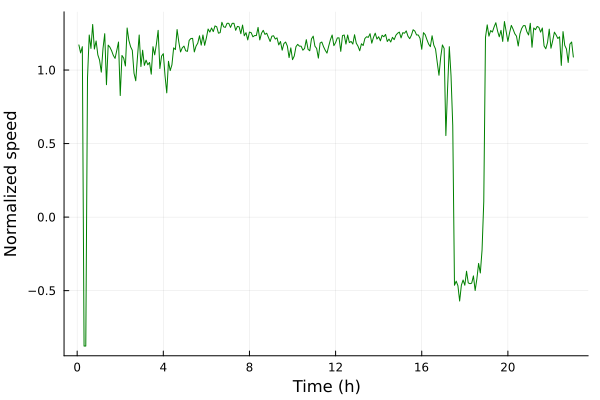

In [84]:
plot_data(g.node_data.features[1:288],1)

In [ ]:
#construct the static graph, the temporal features and targets from the dataset.

In [85]:
begin
    graph = GNNGraph(g.edge_index; edata = g.edge_data, g.num_nodes)
    features = g.node_data.features
    targets = g.node_data.targets
end;  

In [86]:
begin
    train_loader = zip(features[1:200], targets[1:200])
    test_loader = zip(features[2001:2288], targets[2001:2288])
end;

In [87]:
#We use the T-GCN model from the paper T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction, which consists of a graph convolutional network (GCN) and a gated recurrent unit (GRU). The GCN is used to capture spatial features from the graph, and the GRU is used to capture temporal features from the feature time series.

#https://arxiv.org/pdf/1811.05320.pdf

model = GNNChain(TGCN(2 => 100), Dense(100, 1))

GNNChain(Recur(TGCNCell(2 => 100)), Dense(100 => 1))

In [88]:
#We train the model for 100 epochs, using the Adam optimizer with a learning rate of 0.001. We use the mean absolute error (MAE) as the loss function.

function train(graph, train_loader, model)

    opt = Flux.setup(Adam(0.001), model)

    for epoch in 1:100
        for (x, y) in train_loader
            x, y = (x, y)
            grads = Flux.gradient(model) do model
                ŷ = model(graph, x)
                Flux.mae(ŷ, y) 
            end
            Flux.update!(opt, model, grads[1])
        end
        
        if epoch % 10 == 0
            loss = mean([Flux.mae(model(graph,x), y) for (x, y) in train_loader])
            @show epoch, loss
        end
    end
    return model
end

train (generic function with 1 method)

In [89]:
train(graph, train_loader, model)

(epoch, loss) = (10, 0.25858173f0)
(epoch, loss) = (20, 0.26330438f0)
(epoch, loss) = (30, 0.25155517f0)
(epoch, loss) = (40, 0.24221162f0)
(epoch, loss) = (50, 0.22869232f0)
(epoch, loss) = (60, 0.24993986f0)
(epoch, loss) = (70, 0.25140283f0)
(epoch, loss) = (80, 0.22663519f0)
(epoch, loss) = (90, 0.23266065f0)
(epoch, loss) = (100, 0.21869709f0)


GNNChain(Recur(TGCNCell(2 => 100)), Dense(100 => 1))

In [90]:
function plot_predicted_data(graph,features,targets, sensor)
    p = plot(xlabel="Time (h)", ylabel="Normalized speed")
    prediction = []
    grand_truth = []
    for i in 1:3:length(features)
        push!(grand_truth,targets[i][1,sensor,:])
        push!(prediction, model(graph, features[i])[1,sensor,:]) 
    end
    prediction = reduce(vcat,prediction)
    grand_truth = reduce(vcat, grand_truth)
    plot!(p, collect(1:length(features)), grand_truth, color = :blue, label = "Grand Truth", xticks =([i for i in 0:50:250], ["$(i)" for i in 0:4:24]))
    plot!(p, collect(1:length(features)), prediction, color = :red, label= "Prediction")
    return p
end

plot_predicted_data (generic function with 1 method)

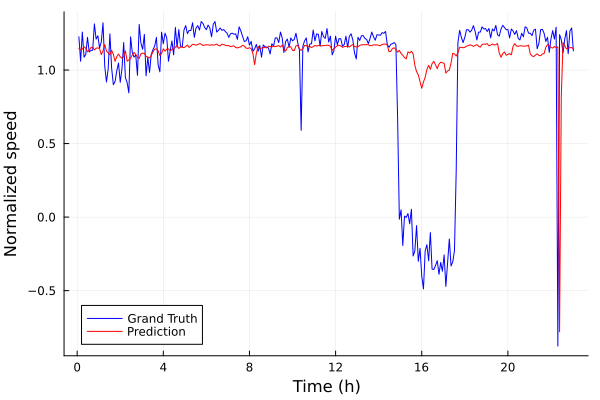

In [91]:
plot_predicted_data(graph,features[301:588],targets[301:588], 1)

In [92]:
accuracy(ŷ, y) = 1 - Statistics.norm(y-ŷ)/Statistics.norm(y)

accuracy (generic function with 1 method)

In [93]:
mean([accuracy(model(graph,x), y) for (x, y) in test_loader])

0.40312448f0

In [ ]:
#use a recurrent temporal graph convolutional network to predict traffic in a spatio-temporal setting. We used the TGCN model, which consists of a graph convolutional network (GCN) and a gated recurrent unit (GRU). We then trained the model for 100 epochs on a small subset of the METR-LA dataset. The accuracy of the model is not very good, but it can be improved by training on more data.